In [1]:
using PyCall
using PyPlot
@pyimport seaborn as sns
using Gync, JLD, Mamba
using Gadfly, ColorBrewer
using KernelDensity

## load markov chains

In [2]:
""" read in lausanne samples """
function lausannedata(path = "../out/fac5err10")
    files   = filter(x -> contains(x, "lausanne"), map(x->abspath("$path/$x"), readdir("../out/fac5err10")))
    lengths = map(f->jldopen(file->size(file["chains"],1), f, "r"), files)
    data = map(f->load(f)["chains"][1:minimum(lengths), :, :], files);
    cat(3, data...)
end
data=lausannedata();

In [ ]:
function newpfizer(path = "../out/fac3err5")
    files   = filter(x -> contains(x, "pfizer"), map(x->abspath("$path/$x"), readdir("../out/fac3err5")))
    lengths = map(f->jldopen(file->size(file["chains"],1), f, "r"), files)
    data = map(f->load(f)["chains"][1:minimum(lengths), :, :], files);
    cat(3, data...)
end
data=newpfizer();

In [3]:
mergechains{T}(data::AbstractArray{T,3}) = vcat([sub(data,:,:,i) for i=1:size(data,3)]...)
onechain = @time mergechains(data);

  5.329715 seconds (194.63 k allocations: 3.351 GB, 4.04% gc time)


In [ ]:
function loadlegacy() # datasets
    fac20err10 = ["../out/fac20err10/$(p)_$c.jld" for c in 1:3, p in 1:3]
    fac5err5   = ["../out/fac5err5/$(p)_$c.jld"   for c in 1:3, p in 1:3]
    fac5err10(p, c) = ["../out/fac5err10/$(p)_$c.jld"  for c in c, p in p]


    files = fac5err10(1:5, 1:3)

    C,P = size(files)

    lengths = map(f->jldopen(file->size(file["chains"],1), f, "r"), files)
    @time alldata = map(f->load(f)["chains"][1:minimum(lengths), :, :], files);
    
    #allchains  = cat(3, alldata...)[1:end,:,:]
    @time allpersons = cat(3,[vcat(alldata[:,p]...) for p=1:P]...)[1:C:end,:,:] #post^p
    #all        = vcat(alldata...)[1:C*P:end,:,:] # pi1
    
    data = allpersons
    mcs = Chains(data, names=[Gync.parameternames[Gync.sampleparms]; Gync.speciesnames])
end

In [129]:
# print all sampled names
function printsamplednames()
    for (i,v) in enumerate(Gync.samplednames)
        print(i, " ",v)
    end
end
printsamplednames()

1 basal LH synthesis rate constant
2 E2 promoted LH synthesis rate constant
3 threshold of E2
4 threshold of P4
5 basal LH release rate constant
6 infuence of GnRH receptor complex on LH release
7 threshold of GnRH on LH release rate
8 blood volume
9 binding rate of LH to its receptor
10 clearance rate of LH from the blood
11 formation rate of free LH receptors
12 desensitization rate of LH receptor complex
13 basal FSH synthesis rate constant
14 threshold of Inhibin A in FSH synthesis
15 threshold of Inhibin B in FSH synthesis
16 threshold of FSH (former GnRH?!) frequency
17 basal FSH release rate constant
18 stimulation of FSH release by GnRH receptor complex
19 threshold of GnRH on FSH release rate
20 binding rate of FSH to its receptor
21 clearance rate of FSH from the blood
22 formation rate of free FSH receptors
23 desensitization rate of FSH receptor complex
24 synthesis rate constant of LH receptors on granulosa cells
25 threshold of FSH-R to stimulate LH receptors on granulosa

## Print of some marginal densities and the first prior estimate

In [32]:
PyPlot.matplotlib[:rc]("savefig", dpi=300)

sns.set_palette(sns.husl_palette(39))
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid")



function plotprior(species, factor=5; kwargs...)
    if species > 82 
        prior = Gync.independentmixtureprior()[species-82]
        min, max = PyPlot.xlim()
        x=linspace(min, max, 200)
        PyPlot.plot(x, pdf(prior, x); kwargs...)
    else
        min = 0
        max = Gync.mleparms[Gync.sampleparms[species]] * factor
        val = 1/(max-min)
        PyPlot.plot([min,max], [val,val]; kwargs...)
    end
end

function plotchain(data::Vector; kwargs...)
    npoints = 2048
    bw = maximum(data) / npoints * 5
    k = kde(data, npoints=2048, bandwidth=bw)
    PyPlot.plot(k.x, k.density; kwargs...)
end

function plotchain(data, species)
    for s=species
        figure()
        speciesdata = data[:,s,:]
        
        sns.set_palette(sns.husl_palette(size(data,3)))
        mapslices(speciesdata, [1]) do persondata
            plotchain(persondata, alpha=0.8, linewidth=0.5)#, color="gray")
        end
        plotprior(s, color="gray")
        plotchain(vec(speciesdata), color=sns.xkcd_rgb["denim blue"])
        xlabel(Gync.samplednames[s][1:end-2])
        PyPlot.display()
    end
end

plotchain (generic function with 2 methods)

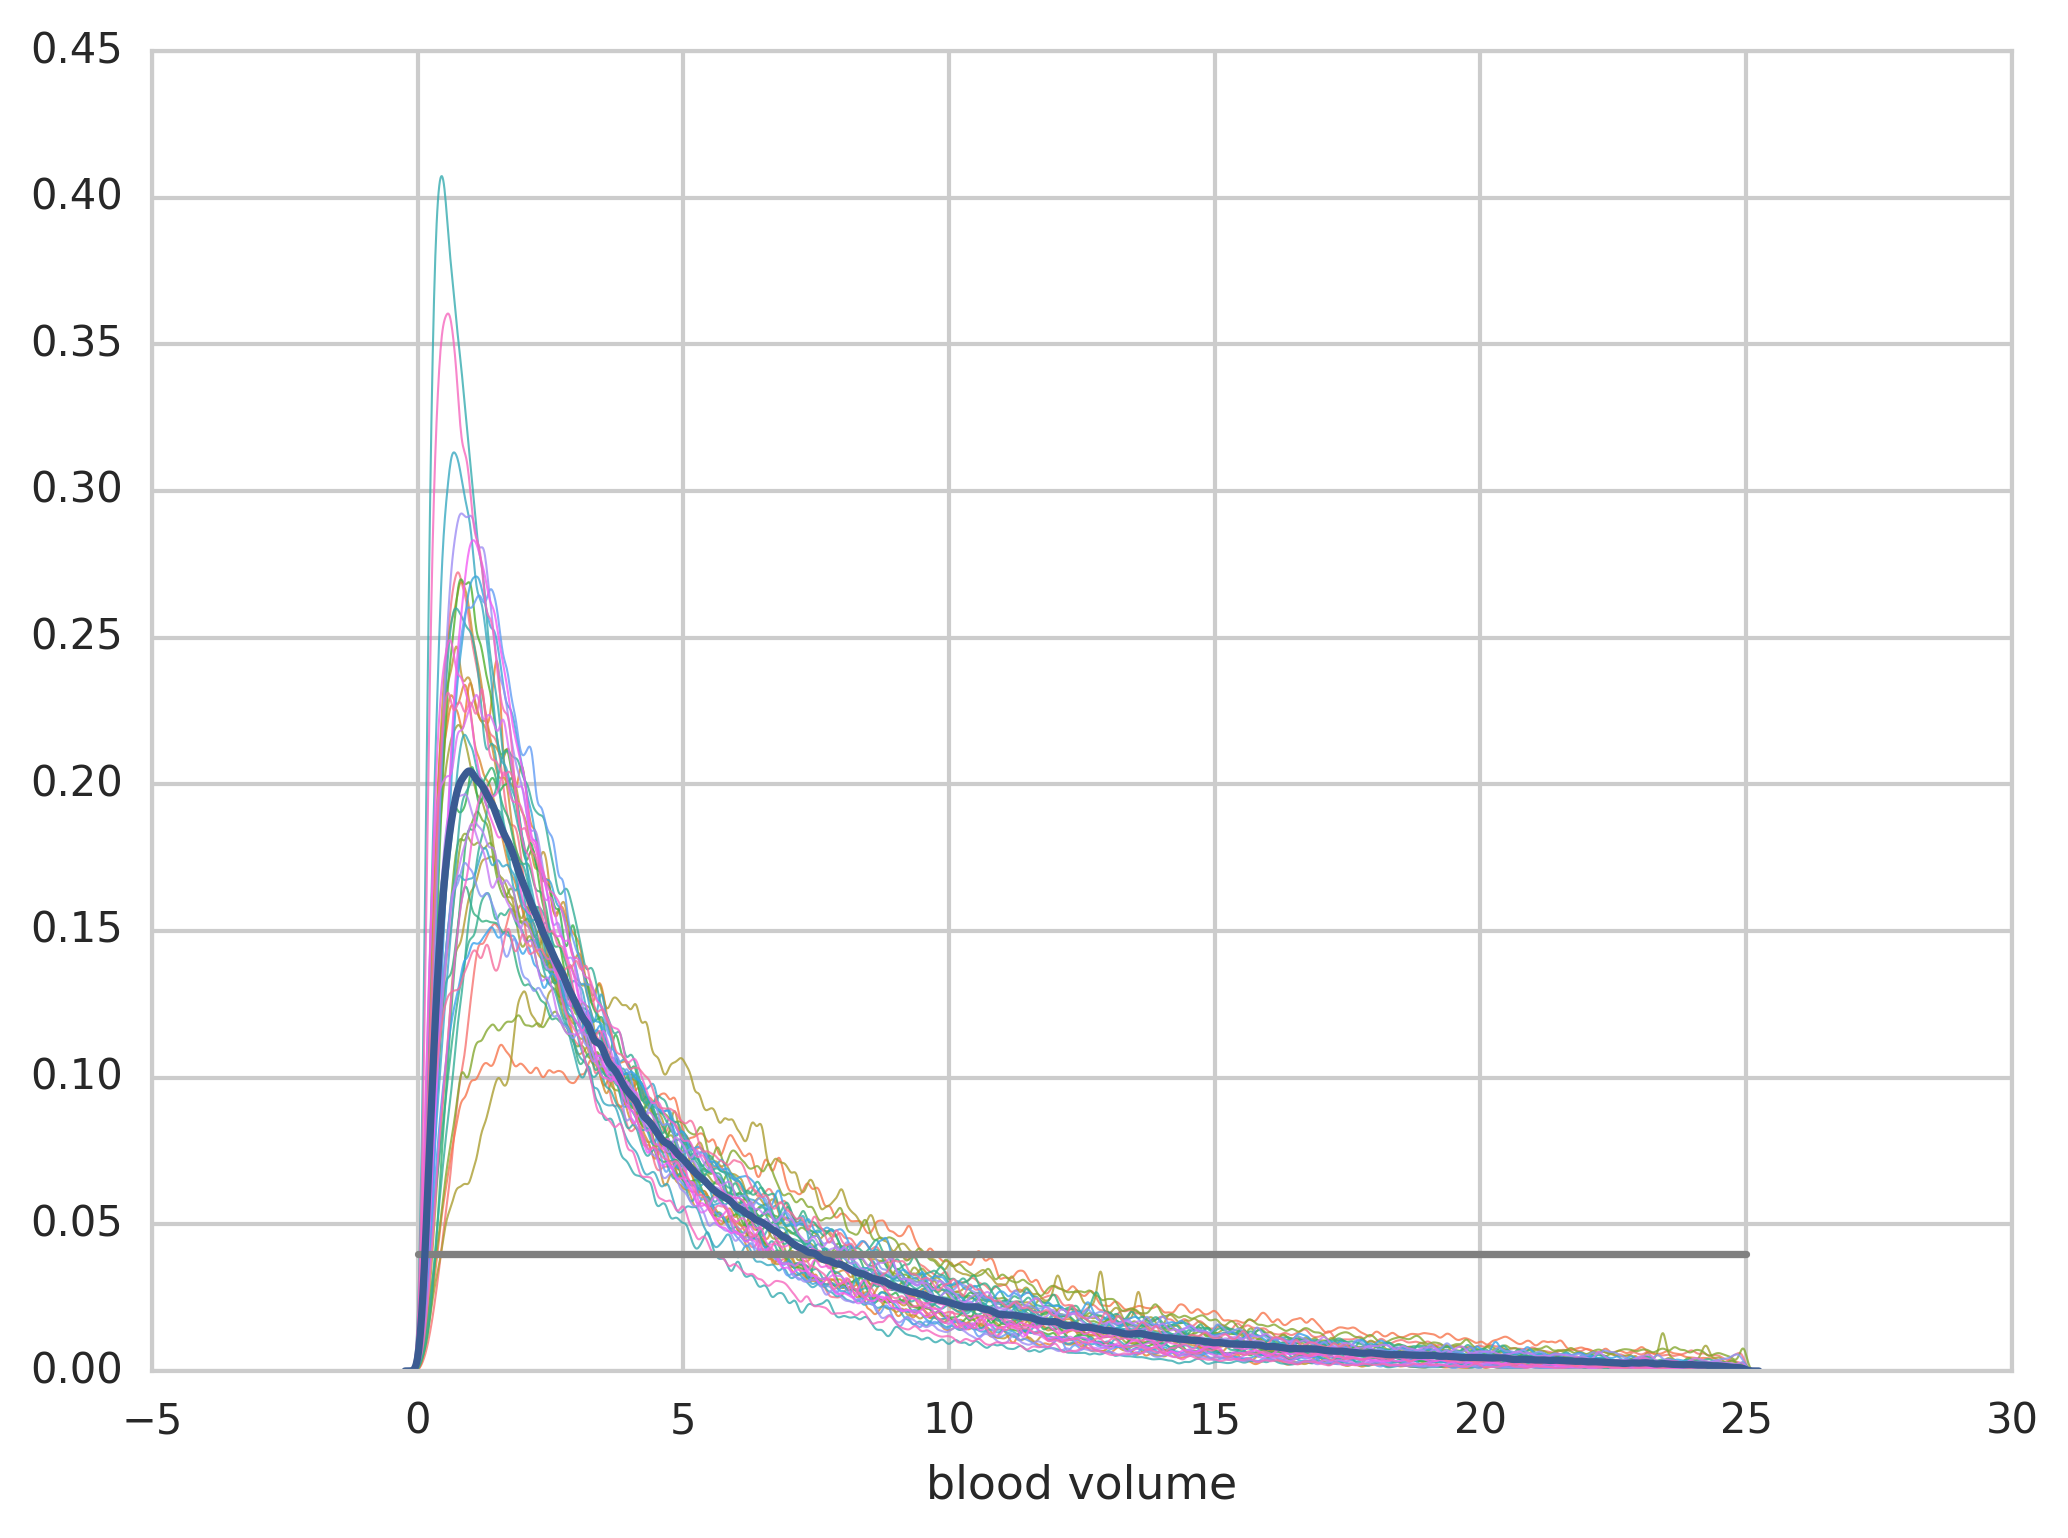

In [33]:
PyPlot.matplotlib[:rc]("savefig", dpi=300)

sns.set(font="DejaVu Sans")
sns.set_style("whitegrid")
sns.set_palette(sns.husl_palette(39))
plotchain(data, 8);

PyPlot.display()
savefig("report marginal post.eps", format="eps")

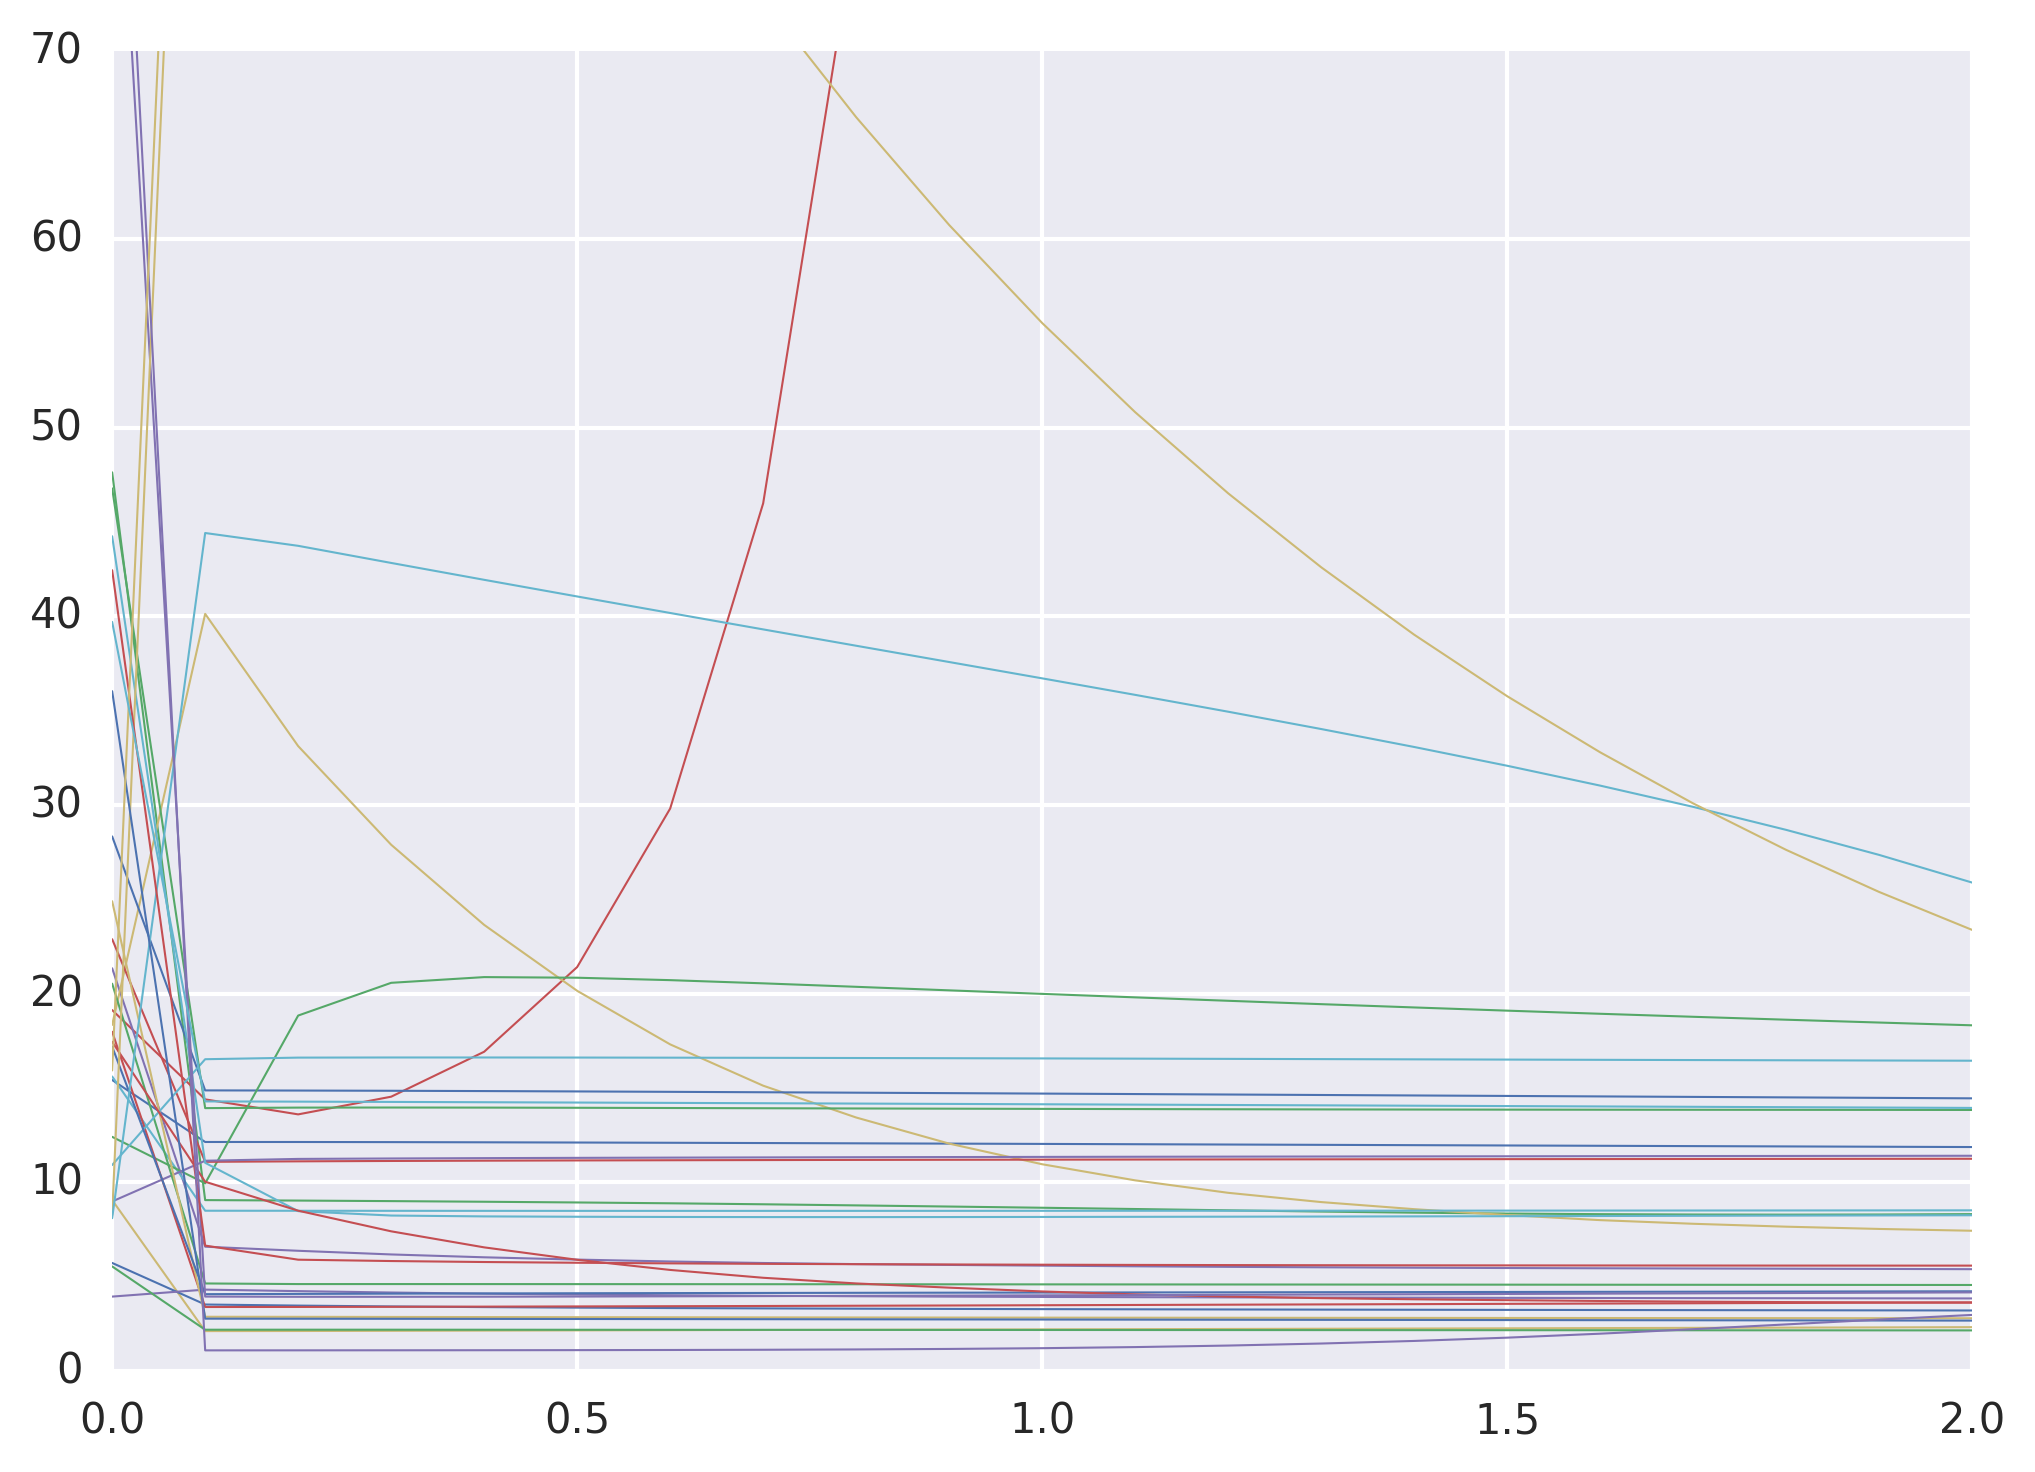

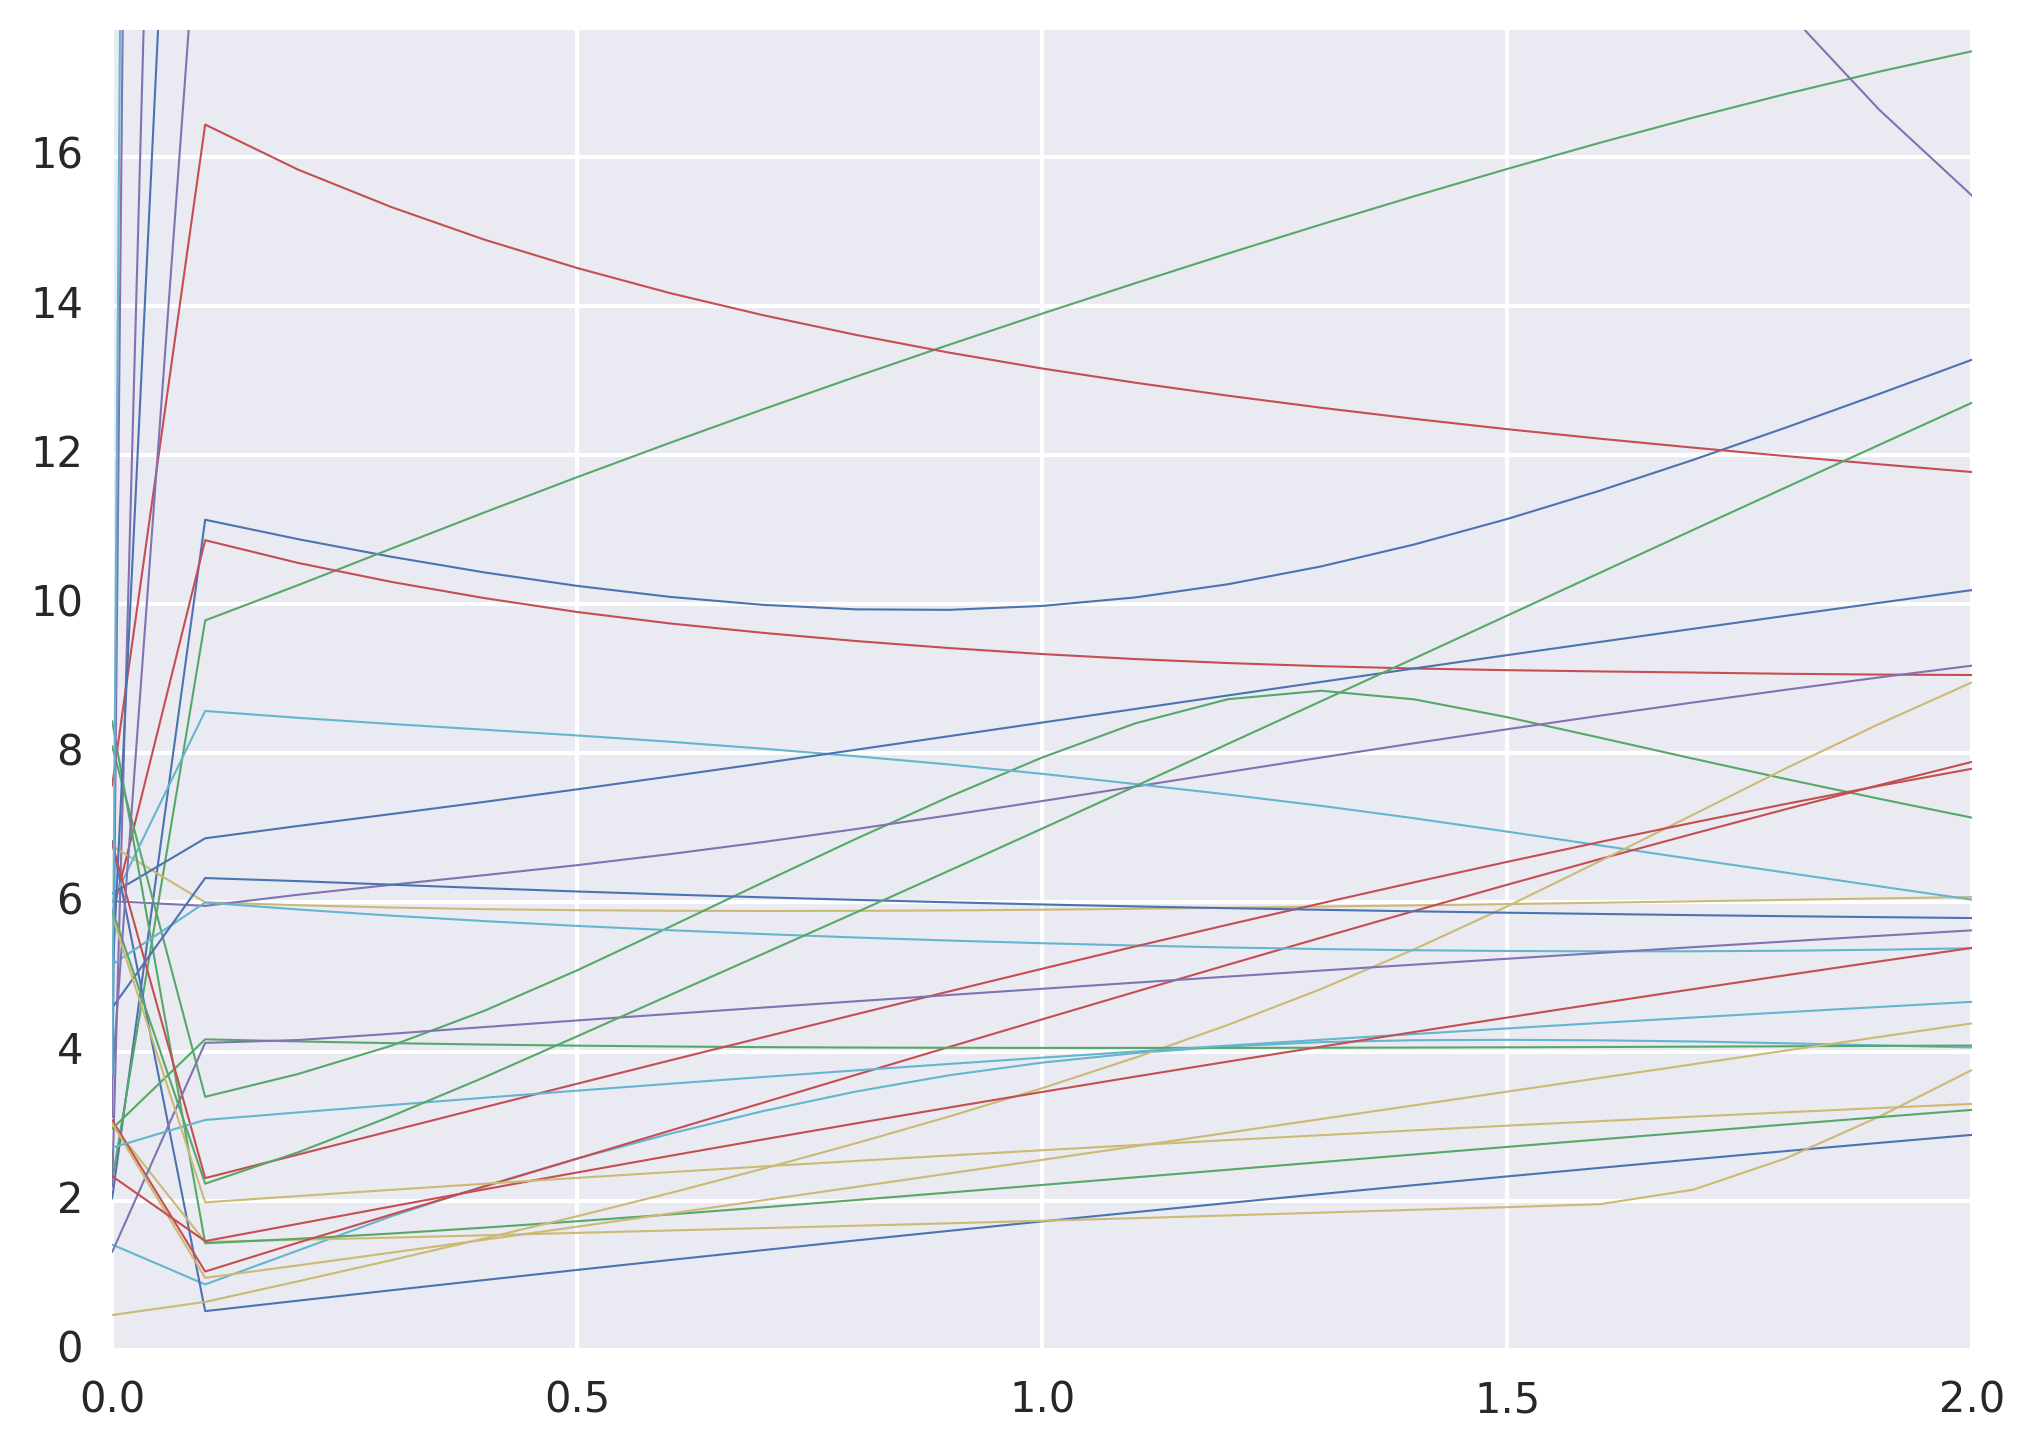

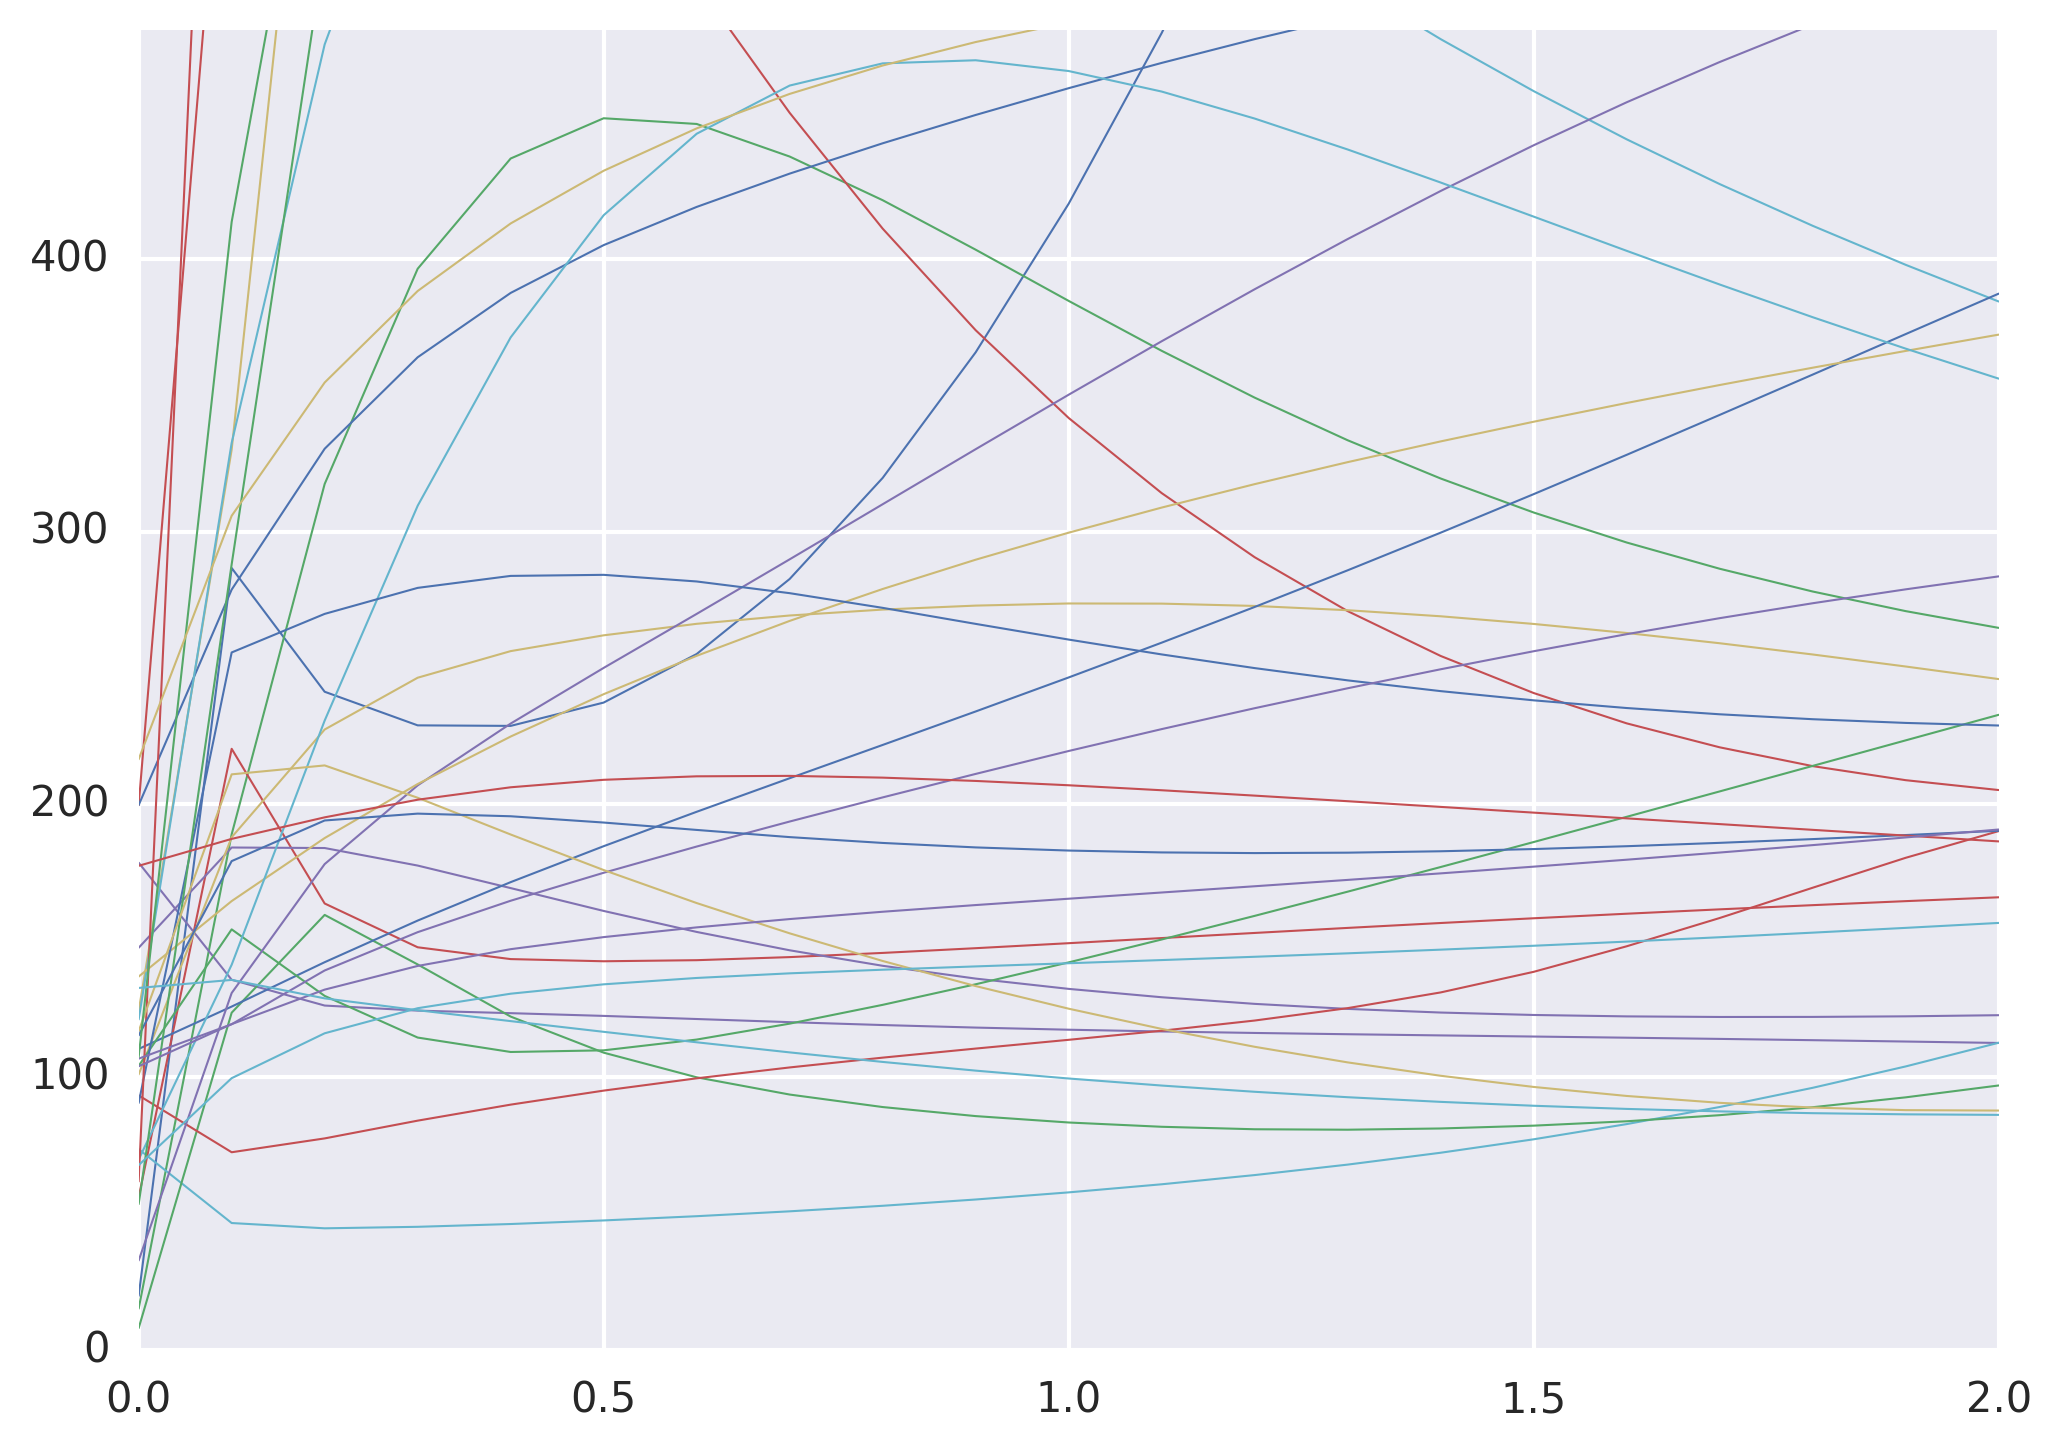

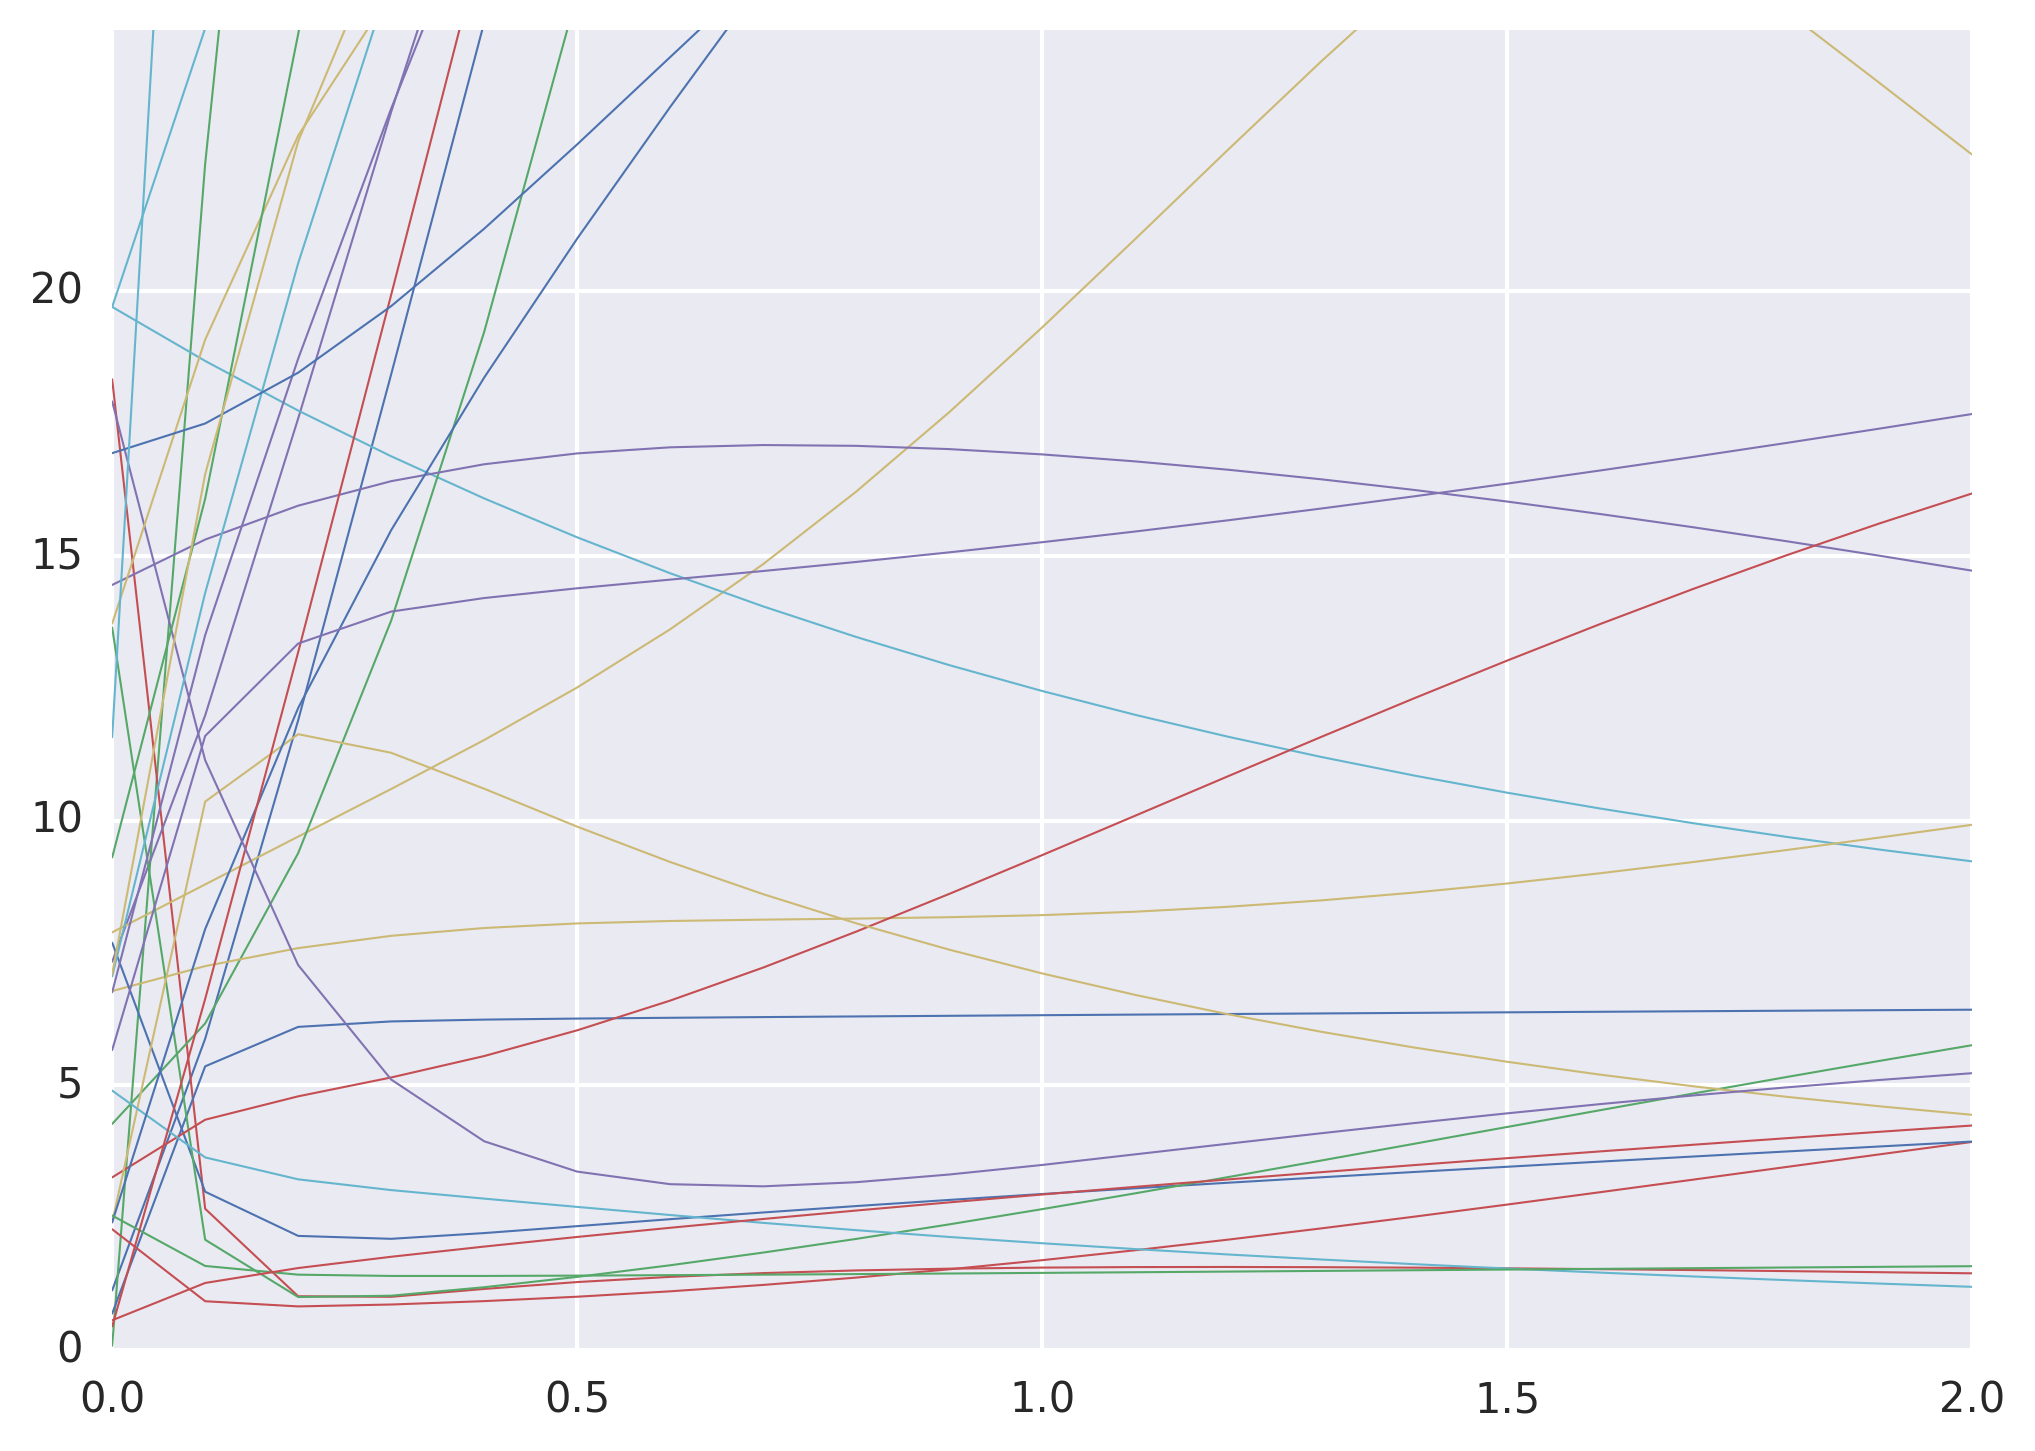

In [128]:
function samplesolution(sample, species)
    sample = vec(sample)
    parms = copy(Gync.mleparms)
    parms[Gync.sampleparms] = sample[1:82]
    y0 = sample[83:115]
    t = Array{Float64}(collect(0:1/10:2))
    y = Gync.gync(y0, t, parms)[species,:] |> vec
    t,y
end

function plotresiduum(person::Int, nlines::Int)
    for species = 1:4
        figure()
        for i=1:nlines
            sample = data[rand(1:size(data,1)),:,person]
            meas = Gync.data(Gync.Subject(:pfizer, person))[species,:] |> vec
            #PyPlot.plot(collect(1:31), meas, "o")
            t,y = samplesolution(sample, Gync.MEASURED[species])
            PyPlot.plot(t,y, linewidth=0.5)
            ylim((0,2*maximum(meas)))
        end
    end
end

plotresiduum(3,30)

In [ ]:
## Plot of the mle solution
t = collect(0:0.1:30)
species = 7
y = Gync.mlegync(t)[species,:]|>vec
PyPlot.plot(t,y)

## Multivariate Analysis

In [ ]:
sns.kdeplot(data[:,8,1], data[:,12,1]); 
xlabel(Gync.samplednames[8]); 
ylabel(Gync.samplednames[12])

## Covariance analysis

In [ ]:
Gync.lausannedata(2)

In [ ]:
reload("Gync")

In [ ]:
map(i->sum(!isnan(Gync.lausannedata(i))),[1:45]) |> mean

Assuming no information besides positivity about the prior distribution  a flat prior is a natural choice, assigning equal probability to each value. For practical purposes we also impose an upper bound of five times the maximum likelihood.
$$ \pi^{\theta}_i = unif\left(\left[0,5\tilde{\theta_i}\right]\right) $$

The prior of the starting values is chosen as mixture distribtuon to  reflect the distribution of the respective species in the nominal cycle via 
$$ \pi^{y_0}_i = \frac{1}{31} \sum_{t=0}^{30} G\left(\tilde{y}(t), \Sigma \right)$$
where $G$ is the Gaussian function, $\tilde y$ the nominal solution and $\Sigma$ 
a diagonal matrix consisting of the squared standard deviations of each species over the whole cycle.

In [ ]:
c=cov(onechain[:,:])
v=1./(sqrt(diag(c)))
r=diagm(v)*c*diagm(v) # pearson correlation
r=r-diagm(diag(r));

sns.heatmap(r)
title("covariances")

topcorr=map(i->ind2sub(size(r),i),sortperm(vec(r), by=abs, rev=true));

function plotcorr(data, s1, s2, log=true)
    figure()
    x = data[:,s1]
    y = data[:,s2]
    c = cov(x,y)
    if log
        x = Base.log(x)
        y = Base.log(y)
    end
    scatter(log(onechain[:,s1]), log(onechain[:,s2]), s=0.5)
    xlabel(Gync.samplednames[s1]), ylabel(Gync.samplednames[s2])
    title(c)
    display()
end

for i=1:2:2*3
    plotcorr(onechain, topcorr[i]...)
end

In [ ]:
nchains(data) = size(data,3)
nsamples(data) = size(data,1)
chainnames(data) = collect(1:nchains(data))

function mlevalue(species)
    layer(Geom.vline, 
        xintercept=[Gync.sampledmles[species]])
end

function plotchains(data; npoints=1024, bincount=30, plottype=:bars, marginal=false)
    @assert size(data,2) == 1
    color = marginal ?
        repeat(["marginal"], inner=[nsamples(data)*nchains(data)]) :
        repeat(chainnames(data), inner=[nsamples(data)])
    geom  = plottype == :dens?
        (Geom.LineGeometry, Stat.density(npoints)):
        (Geom.bar(position=:dodge), Stat.histogram(bincount=bincount))
    layer(x=data[:,:,:], color=color, geom...)
end

function plotspecies(data, species::Int)
    chains   = plotchains(data[:,species,:])    
    marginal = plotchains(data[:,species,:], marginal=true)
    mle      = mlevalue(species)
    
    Gadfly.add_plot_element!(marginal,Theme(line_width=3pt))
    
    p = plot(marginal, chains, mle,  
        Scale.color_discrete(),
        #Guide.colorkey("Person"),
        Coord.Cartesian(xmin=0),
        Guide.xlabel(Gync.samplednames[species]),
        Theme(key_position = :none))
    
    draw(SVG(8inch, 5inch), p)
    #display(p)
    p
end

plotspecies(data, species::Vector{Int}) = map(s->plotspecies(data,s), species)
    
#plotspecies(allpersons[1:300:end,:,:], [8])
plot(plotchains(allpersons[1:end,8,1], marginal=true, bincount=100))

In [ ]:
using Mamba
mcs = Chains(data, names=[Gync.parameternames[Gync.sampleparms]; Gync.speciesnames]);

In [ ]:
plotspecies = [8, 9, 20, 39, 84, 89, 106, 107]
#plotspecies = Colon()
burnin = 0
#types = [:trace, :autocor, :mean, :density]
types = [:trace]
step = 10


@time plots = Mamba.plot(mcs[burnin+1:step:end,plotspecies,:], types, trim=(0,1), legend=true)

@time Mamba.draw(plots, ask=false, fmt=:png, ncol=length(types))

# TODO
- plot blutvolume/fsh (barplot, 10 bars, post pro person)
- plot pi1 (bar oder kurve)
- plot iterations

# Gedanken zur Iteration
- samplingfehler (randomness in n) vs diskretisierungsfehler (anzahl der y) vs sigma
- groses sigma -> ein peak?
- abbruchskriterium / regularisierung
- einfluss der dimension

In [ ]:
import Gync: sampledmles
using Gadfly: layer, Geom
using ColorBrewer

addmle!(plot::Gadfly.Plot, species::Int) = push!(plot, layer(Geom.vline, xintercept=[Gync.sampledmles[species]]))

function analyse(mcs)
    [analyse_single(mcs[:,i,:]) for i = 1:size(mcs,2)]
end

function analyse_single(mc)
    size(mc,2) == 1 || error("chain contains multiple variables")
    const plotresolution = 20_000
    
    step = max(round(Int, size(mc, 1) / plotresolution), 1)
    p = plot(mc[1:step:end,:,:], :density, trim=(0,1), legend=true, format=:PNG)[1]
    species = findnext(Gync.samplednames, mc.names[1],1)
    addmle!(p, species)
    
    colors = vcat(map(c->palette(c, 6)[3:5], ["GnBu", "Greys", "Oranges"])...)
    push!(p, Gadfly.Scale.color_discrete_manual(colors...))

    
    if size(mc,3) > 1 
        gelman = gelmandiag(mc[:,:,:])
        println("Gelman Rubin (PSRF, 97.5%): ", string(gelman.value))
    end
    display(p)
    p
end

In [ ]:
plots = analyse(mcs[burnin:step:end,plotspecies,:]);

In [ ]:
rafterydiag = Mamba.rafterydiag(mcs[:,[1:5:115],:])

In [ ]:
x=gelmandiag(mcs[:,:,1:3])
#notc = x.value[:,2].>1.2
#[find(notc) x.value[notc,2]]

In [ ]:
# compute the acceptance rate of each markov chain
acceptance(mc::Array) = mapslices(mc,[1,2]) do mc
    n = size(mc,1)
    sum([mc[i,:,:] != mc[i+1,:,:] for i in 1:n-1]) / (n-1);
  end |> vec

acceptance(c::AbstractChains) = acceptance(c.value)

function loglikelihood(mc::Array{Float64,3}, data::Matrix)
    mapslices(mc, 2) do sample
        loglikelihood(data, sampletoparms(sample)...)
    end
end

loglikelihood(mc::AbstractChains, data::Matrix) = loglikelihood(mc.value, data);

In [ ]:
parms, y0 = loadparms()
SIGMA_RHO = 0.2
SIGMA_Y0  = 1
SIGMA_PARMS = 20
SIGMA_PROPOSAL = 0.1
l=loglikelihood(mcs[1:5000:end,:,:], loadpfizer()[1])

In [ ]:
map(i -> mean(l[2:end,:,i]), 1:5)